In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_points(file):
    """
        file: source points file
    """
    samples = []
    for row in file.readlines():
        sample = row.rstrip()[1:-1].split(',')
        sample = np.asarray(sample).astype(np.int)
        samples.append(sample)
    
    samples = np.asarray(samples)
    return samples

def draw_points(points, img, color=(0, 255, 0)):
    """
        points: shape keypoints with dim [num_keypoints x 2]
        img: The source image
    """
    for point in points:
        cv2.circle(img, tuple(point), 1, color, 2)

Load and Visualize data:

Lanmarks Shape:  (65, 2)


C:\Users\Алексей\AppData\Local\Temp\ipykernel_852\1741893322.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample = np.asarray(sample).astype(np.int)


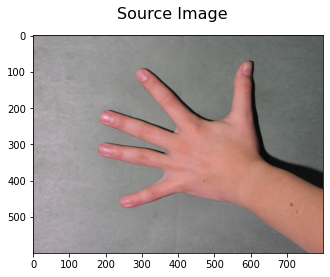

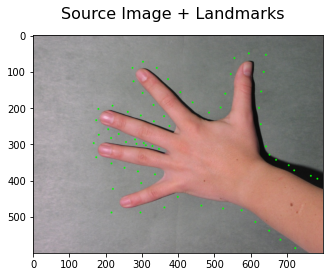

In [3]:
image_path = './data/hand.jpg'
landmarks_path = './data/hand_landmarks.txt'

with open(landmarks_path, 'r') as file:
    landmarks = load_points(file)
    print("Lanmarks Shape: ",landmarks.shape)
    
img = cv2.imread(image_path)
b,g,r = cv2.split(img) 
img = cv2.merge([r,g,b])
fig = plt.figure()
fig.suptitle('Source Image', fontsize=16)
plt.imshow(img)

clone_img = img.copy()
draw_points(landmarks, clone_img)
fig = plt.figure()
fig.suptitle('Source Image + Landmarks', fontsize=16)
plt.imshow(clone_img)

Detecting edges using Canny:

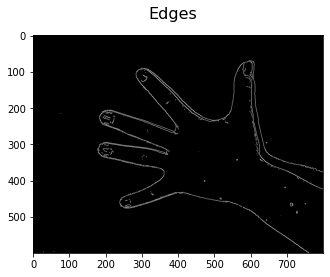

In [4]:
edges = cv2.Canny(img, 90, 100)
fig = plt.figure()
fig.suptitle('Edges', fontsize=16)
plt.imshow(edges, cmap='gray')

Compute the distances to the edges:

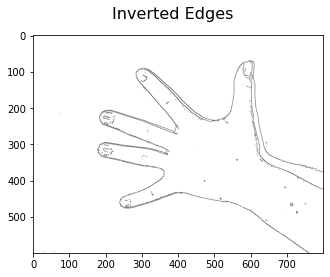

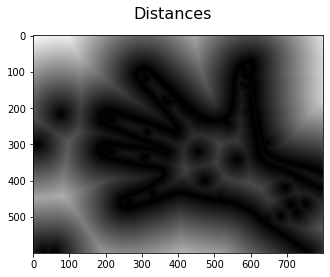

In [5]:
inverted_edges = edges.max() - edges
fig = plt.figure()
fig.suptitle('Inverted Edges', fontsize=16)
plt.imshow(inverted_edges, cmap='gray')

dist = cv2.distanceTransform(src=inverted_edges, 
                             distanceType=cv2.DIST_L2, 
                             maskSize=cv2.DIST_MASK_PRECISE)
fig = plt.figure()
fig.suptitle('Distances', fontsize=16)
plt.imshow(dist*255, cmap='gray')

Gradient:

In [6]:
def gradient(dist, e):
    """
        dist: Distances
        e: 
        return: gx, gy: Gradient X, Y
    """
    shifted_right = np.roll(dist, e, axis=1)
    shifted_left = np.roll(dist, -e, axis=1)
    shifted_down = np.roll(dist, e, axis=0)
    shifted_up = np.roll(dist, -e, axis=0)
    
    gx = (shifted_right - shifted_left)/2
    gy = (shifted_down - shifted_up)/2
    
    return gx, gy

Correspondences:

In [7]:
def correspondences(dist, gx, gy, eps=0.0001):
    """
        dist: Distances
        gx:
        gy:
        eps: epsilon
        return:
    """
    Gyx = np.stack((gy, gx), axis=0)
    wx = np.ones(dist.shape) * np.arange(dist.shape[1])
    wy = np.arange(dist.shape[0]).reshape(-1,1) * np.ones(dist.shape)
    X = np.stack((wy, wx), axis=0)
    K = Gyx * dist / (np.sqrt(np.power(gx,2) + np.power(gy,2)) + eps)
    X += K
    
    return np.moveaxis(X, 0, -1)

gx, gy = gradient(dist, 1)
X = correspondences(dist, gx, gy)


ICP:

In [19]:
def project_points(points):
    """
        points: unprojeted points [ K x 2]
        return: projected points  [2K x 6]
    """
    
    repeat_points = np.repeat(points, 2, axis=0)
    masks = np.array([[0, 0, 1, 0], [0, 1, 0, 0]])
    repeat_masks = np.repeat([masks], points.shape[0], axis=0).reshape(-1, 4)
    assert repeat_points.shape[0] == repeat_masks.shape[0]
    
    print(repeat_points, repeat_masks)
    
    # concating the points and the masks
    new_points = np.concatenate((repeat_points, repeat_masks), axis=1)
    assert new_points.shape == (2 * points.shape[0], 6)
    
    print(new_points)
    # shifting the odd rows by 2
    new_points[1::2] = np.roll(new_points[1::2], 2)
    print(new_points)
    
    return new_points

In [9]:
A = project_points(landmarks[:, [1, 0]])

[[586 723]
 [586 723]
 [563 682]
 [563 682]
 [538 651]
 [538 651]
 [514 613]
 [514 613]
 [482 575]
 [482 575]
 [477 524]
 [477 524]
 [469 464]
 [469 464]
 [445 399]
 [445 399]
 [474 362]
 [474 362]
 [488 296]
 [488 296]
 [488 216]
 [488 216]
 [423 220]
 [423 220]
 [407 298]
 [407 298]
 [383 336]
 [383 336]
 [375 289]
 [375 289]
 [365 252]
 [365 252]
 [353 216]
 [353 216]
 [336 174]
 [336 174]
 [297 167]
 [297 167]
 [274 181]
 [274 181]
 [283 215]
 [283 215]
 [294 256]
 [294 256]
 [299 285]
 [299 285]
 [303 311]
 [303 311]
 [313 347]
 [313 347]
 [305 329]
 [305 329]
 [297 305]
 [297 305]
 [287 281]
 [287 281]
 [272 236]
 [272 236]
 [259 207]
 [259 207]
 [234 174]
 [234 174]
 [203 180]
 [203 180]
 [194 219]
 [194 219]
 [211 261]
 [211 261]
 [221 297]
 [221 297]
 [237 333]
 [237 333]
 [250 376]
 [250 376]
 [223 361]
 [223 361]
 [192 332]
 [192 332]
 [159 302]
 [159 302]
 [127 277]
 [127 277]
 [ 90 274]
 [ 90 274]
 [ 73 303]
 [ 73 303]
 [ 90 341]
 [ 90 341]
 [121 372]
 [121 372]
 [157 406]

C:\Users\Алексей\AppData\Local\Temp\ipykernel_852\2507497893.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new_points = np.around(new_points).astype(np.int)


[[549 713]
 [549 713]
 [529 673]
 [529 673]
 [509 645]
 [509 645]
 [487 611]
 [487 611]
 [461 576]
 [461 576]
 [460 529]
 [460 529]
 [453 473]
 [453 473]
 [432 416]
 [432 416]
 [458 381]
 [458 381]
 [472 322]
 [472 322]
 [472 250]
 [472 250]
 [415 252]
 [415 252]
 [399 323]
 [399 323]
 [377 358]
 [377 358]
 [369 315]
 [369 315]
 [362 280]
 [362 280]
 [352 248]
 [352 248]
 [341 210]
 [341 210]
 [306 202]
 [306 202]
 [287 215]
 [287 215]
 [293 248]
 [293 248]
 [302 284]
 [302 284]
 [305 309]
 [305 309]
 [307 333]
 [307 333]
 [314 366]
 [314 366]
 [308 351]
 [308 351]
 [302 328]
 [302 328]
 [295 305]
 [295 305]
 [283 265]
 [283 265]
 [272 240]
 [272 240]
 [250 207]
 [250 207]
 [222 212]
 [222 212]
 [213 249]
 [213 249]
 [229 287]
 [229 287]
 [237 320]
 [237 320]
 [249 352]
 [249 352]
 [257 392]
 [257 392]
 [237 377]
 [237 377]
 [210 350]
 [210 350]
 [181 323]
 [181 323]
 [153 300]
 [153 300]
 [120 298]
 [120 298]
 [105 323]
 [105 323]
 [119 357]
 [119 357]
 [147 386]
 [147 386]
 [179 418]

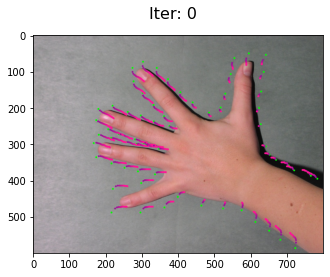

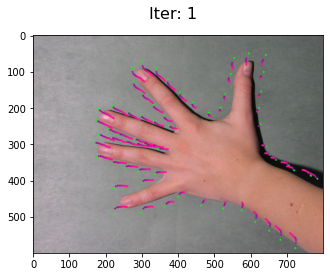

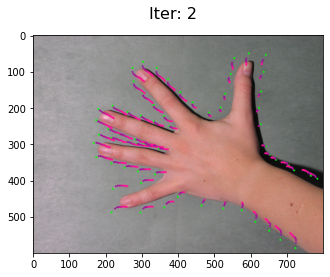

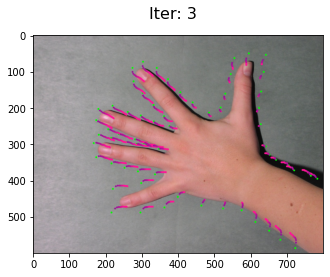

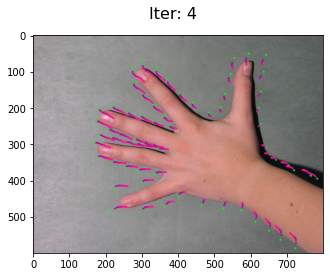

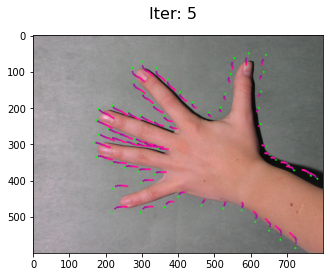

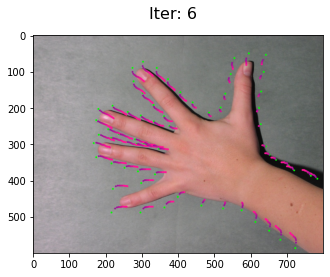

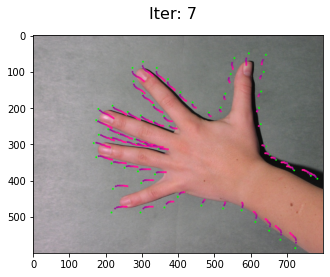

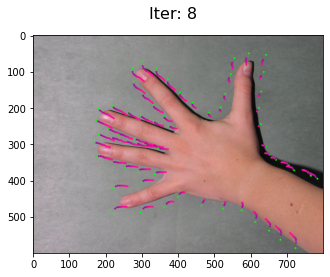

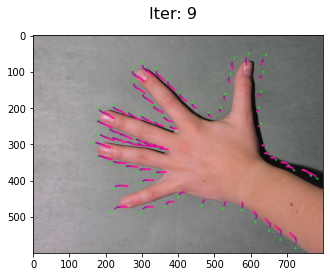

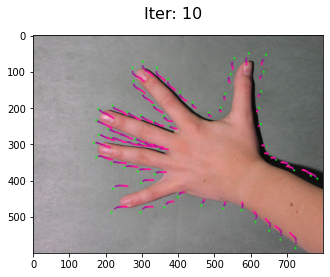

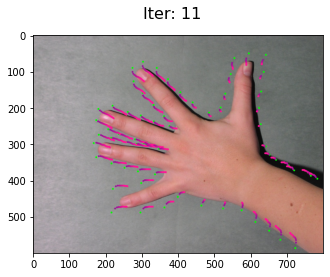

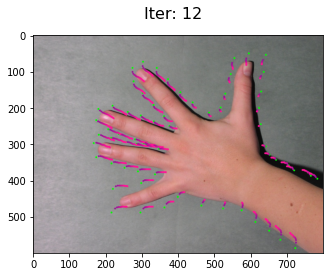

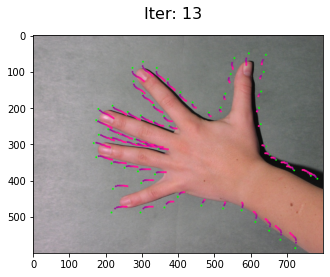

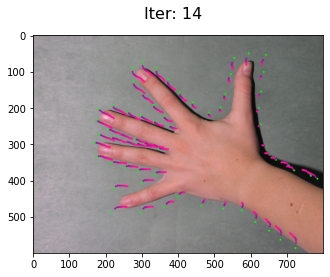

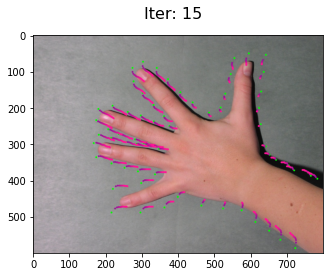

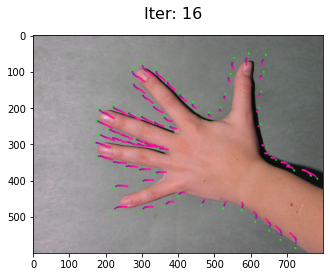

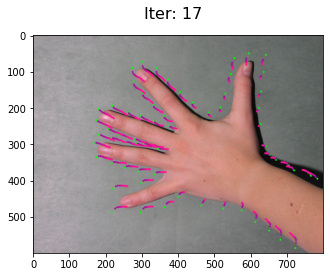

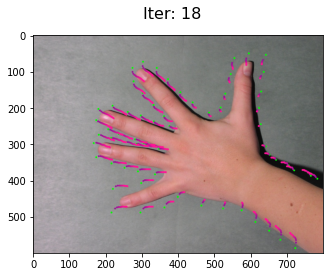

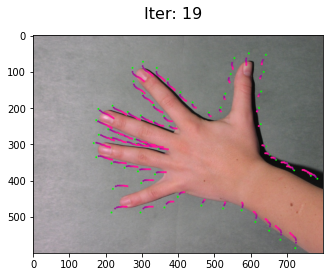

In [20]:
 
iterations = 20
psi = np.ones((3,3))
# Ax = b
# Initial W = Landmarks
W = landmarks[:, [1,0]]
# print(W)
for i in range(iterations):
    
    A = project_points(W)
#     print(W)
    b = X[W[:,0], W[:,1]].reshape(-1)
    (x, res, rank, s) = np.linalg.lstsq(A, b, rcond=-1)  # Ax=b
    psi = x
    #update the points using the estimated psi
    new_points = np.dot(A, psi)
    new_points = np.around(new_points).astype(np.int)
    W = new_points.reshape(-1, 2)
    
    W[:, 0][W[:, 0] > 599] = 599
    W[:, 1][W[:, 1] > 799] = 799
    color = (150 + i*10, 20, 150)
    draw_points(W[:,[1,0]], clone_img, color)
    fig = plt.figure()
    fig.suptitle('Iter: %d'%(i), fontsize=16)
    plt.imshow(clone_img)
    
    
    
    
    